In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import molfeat
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import LeaveOneOut, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold

import autosklearn.regression

from tdc.chem_utils import MolConvert

import matplotlib

def save_fig(ax,file_path):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt_ = ax.get_figure()
    plt_.tight_layout()
    plt_.savefig(file_path, transparent=True)
    return

config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [2]:
data = pd.read_csv("../data/ah_selected_autoqchem.csv")
data

,smiles,c_index,x_index,global_number_of_atoms,global_charge,global_multiplicity,global_dipole,global_molar_mass,global_molar_volume,global_electronic_spatial_extent,...,local_ES_root_NPA_charge,local_ES_root_NPA_core,local_ES_root_NPA_valence,local_ES_root_NPA_Rydberg,local_ES_root_NPA_total,from_cas,from_hammett,from_informer,local_NMR_pred,Halide
0,Ic1ccccc1,1,0,12.0,0.0,1.0,1.6679,204.0100,615.024,1115.9615,...,-0.25947,1.99874,4.22962,0.03111,6.25947,True,True,False,107.270717,I
1,Ic1ccc(OC)cc1,1,0,16.0,0.0,1.0,2.6921,234.0362,1093.317,2040.0494,...,-0.24487,1.99876,4.21315,0.03297,6.24487,True,True,False,100.034967,I
2,Brc1ccccc1,1,0,12.0,0.0,1.0,1.7385,157.0095,903.584,1225.4453,...,-0.10703,1.99861,4.08679,0.02164,6.10703,True,True,False,115.090854,Br
3,Ic1ccc(C)cc1,1,0,15.0,0.0,1.0,2.1001,218.0368,1220.972,1584.3176,...,-0.25055,1.99874,4.22017,0.03164,6.25055,True,True,False,103.867765,I
4,Brc1ccc(OC)cc1,1,0,16.0,0.0,1.0,2.7364,187.0357,1176.890,2371.2266,...,-0.07174,1.99857,4.05177,0.02140,6.07174,True,True,False,102.766665,Br
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Ic1c(F)cc(N2C[C@H](Cn3ccnn3)OC2=O)cc1,1,0,30.0,0.0,1.0,6.7206,388.1395,1830.183,9430.2534,...,-0.32377,1.99866,4.29199,0.03312,6.32377,False,False,True,85.460168,I
758,Ic1ccc2nc(CCC)n(Cc3ccc(-c4c(S(=O)(NC(C)(C)C)=O...,1,0,66.0,0.0,1.0,5.8570,615.5278,4063.149,28878.2024,...,-0.17989,1.99863,4.15534,0.02592,6.17989,False,False,True,103.994023,I
759,Clc1cc2c(cc1C)[C@H](C(NC(C)=O)(C)C)CC21CCN(C(O...,1,0,65.0,0.0,1.0,3.5202,435.0051,3751.365,19158.0870,...,-0.02558,1.99850,4.00491,0.02217,6.02558,False,False,True,117.879348,Cl
760,Clc1ccc2c(c1)[C@@](C#CC1CC1)(C(F)(F)F)OC(=O)N2,1,0,30.0,0.0,1.0,4.0266,315.6788,2041.573,6460.4729,...,0.01525,1.99854,3.96389,0.02232,5.98475,False,False,True,106.895327,Cl


In [3]:
embeddings_scope = get_embedding_from_smi(data.smiles.to_list(), data.c_index.to_list(), model_pretrained, device)

In [4]:
transformer = MolConvert(src = 'SMILES', dst = 'RDKit2D')
embeddings_rdkit2d = transformer(data.smiles.to_list())

In [5]:
transformer = MolConvert(src = 'SMILES', dst = 'Morgan')
embeddings_morgan = transformer(data.smiles.to_list())

In [6]:
transformer = MolConvert(src = 'SMILES', dst = 'MACCS')
embeddings_maccs = transformer(data.smiles.to_list())

In [7]:
# from molfeat.trans import MoleculeTransformer
# transformer = MoleculeTransformer(featurizer='mordred', dtype=float)
# embeddings_mordred = transformer(data.smiles.to_list())

In [8]:
from molfeat.trans.pretrained import PretrainedDGLTransformer
transformer = PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float)
embeddings_masking = transformer(data.smiles.to_list())


2023-12-20 23:20:30 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2023-12-20 23:20:30 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: [Errno 113] No route to host
2023-12-20 23:20:33 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 3 of 3. Reason: timed out
2023-12-20 23:20:33 | WARNING | google.auth._default | Authentication failed using Compute Engine authentication due to unavailable metadata server.
2023-12-20 23:20:33 | WARNING | google.auth.compute_engine._metadata | Compute Engine Metadata server unavailable on attempt 1 of 5. Reason: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at

In [9]:
embeddings_chemgpt = np.load("../data/ah_selected_autoqchem_chemgpt.npy")

In [10]:
embeddings_scope.shape, embeddings_rdkit2d.shape, embeddings_maccs.shape, embeddings_morgan.shape, embeddings_masking.shape, embeddings_chemgpt.shape

((762, 64), (762, 200), (762, 167), (762, 1024), (762, 300), (762, 128))

In [11]:
data.columns

Index(['smiles', 'c_index', 'x_index', 'global_number_of_atoms',
       'global_charge', 'global_multiplicity', 'global_dipole',
       'global_molar_mass', 'global_molar_volume',
       'global_electronic_spatial_extent', 'global_E_scf',
       'global_zero_point_correction', 'global_E_thermal_correction',
       'global_H_thermal_correction', 'global_G_thermal_correction',
       'global_E_zpe', 'global_E', 'global_H', 'global_G',
       'global_stoichiometry', 'global_converged', 'global_homo_energy',
       'global_lumo_energy', 'global_electronegativity', 'global_hardness',
       'global_ES_root_dipole', 'global_ES_root_molar_volume',
       'global_ES_root_electronic_spatial_extent', 'local_X', 'local_Y',
       'local_Z', 'local_VBur', 'local_Mulliken_charge', 'local_APT_charge',
       'local_NPA_charge', 'local_NPA_core', 'local_NPA_valence',
       'local_NPA_Rydberg', 'local_NPA_total', 'local_NMR_shift',
       'local_NMR_anisotropy', 'local_ES_root_Mulliken_charge',
     

In [12]:
embedding_list = ['ContraScope', 'RDKit2D', 'MACCS', 'Morgan', 'AttrMask', 'ChemGPT']
prediction_targets = ['global_homo_energy', 'global_lumo_energy', 'global_electronegativity', 'global_hardness', 'local_VBur', 'local_Mulliken_charge', 'local_APT_charge', 'local_NPA_charge', 'local_NPA_core', 'local_NPA_valence', 'local_NPA_Rydberg', 'local_NPA_total', 'local_NMR_shift', 'local_NMR_anisotropy']

# embedding_list = ['morgan', 'maccs']
# prediction_targets = ['local_VBur', 'local_Mulliken_charge']

In [15]:
data_list = []

for embedding in embedding_list:
    if embedding == 'ContraScope':
        X = embeddings_scope
    elif embedding == 'RDKit2D':
        X = embeddings_rdkit2d
    elif embedding == 'MACCS':
        X = embeddings_maccs
    elif embedding == 'Morgan':
        X = embeddings_morgan
    elif embedding == 'mordred':
        X = embeddings_mordred
    elif embedding == 'AttrMask':
        X = embeddings_masking
    elif embedding == 'ChemGPT':
        X = embeddings_chemgpt
    
    print(f"Embedding: {embedding}")
    for target in prediction_targets:

        print(f"Target: {target}")

        model_list = ['linear', 'lasso', 'ridge', 'svr', 'knn']
        y = data[target].to_numpy()

        max_r2 = -9999
        for model in model_list:
            if model == 'linear':
                reg = LinearRegression()
            elif model == 'lasso':
                reg = Lasso(alpha=0.1)
            elif model == 'ridge':
                reg = Ridge(alpha=.5)
            elif model == 'svr':
                reg = SVR(kernel='linear', C=1.0, epsilon=0.2)
            elif model == 'mlp':
                reg = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0)
            elif model == 'knn':
                reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')
            elif model == 'rf':
                reg = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=0)

            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            cv_results = cross_validate(predictor, X, y, cv=3, scoring='r2', return_train_score=True)
            if cv_results['test_score'].mean() > max_r2:
                best_cv_results = cv_results
                max_r2 = cv_results['test_score'].mean()

        print(best_cv_results)

        data_list.append([embedding, target, best_cv_results['test_score'][0]])
        data_list.append([embedding, target, best_cv_results['test_score'][1]])
        data_list.append([embedding, target, best_cv_results['test_score'][2]])

            # print(f"Embedding: {embedding:8}, Target: {target:16}, Model: {model:8}, 4-cv r2: {cv_results['test_score'].mean():.3f} +/- {cv_results['test_score'].std():.3f}")

Embedding: ContraScope
Target: global_homo_energy
{'fit_time': array([0.00121117, 0.00115418, 0.00113893]), 'score_time': array([0.0040977 , 0.00417948, 0.00427651]), 'test_score': array([0.14087945, 0.3377995 , 0.00117549]), 'train_score': array([0.99707562, 0.99678761, 0.9954418 ])}
Target: global_lumo_energy
{'fit_time': array([0.00112987, 0.00116062, 0.00111818]), 'score_time': array([0.00406051, 0.00417662, 0.00425267]), 'test_score': array([ 0.37654684,  0.16024132, -0.01568835]), 'train_score': array([0.99694907, 0.99360935, 0.99564673])}
Target: global_electronegativity
{'fit_time': array([0.00116014, 0.00118017, 0.00111985]), 'score_time': array([0.00416279, 0.00425005, 0.00425839]), 'test_score': array([0.20402822, 0.2403658 , 0.02711319]), 'train_score': array([0.99798633, 0.99466562, 0.99562457])}
Target: global_hardness
{'fit_time': array([0.00118399, 0.00113487, 0.00114131]), 'score_time': array([0.00409198, 0.0042057 , 0.00427651]), 'test_score': array([ 0.47616657,  0.2

In [16]:
temp = pd.DataFrame(data_list, columns=['embedding', 'target', 'r2'])
temp = temp[temp['target'] != 'global_electronegativity'][temp['target'] != 'global_homo_energy'][temp['target'] != 'global_lumo_energy'][temp['target'] != 'global_hardness'][temp['target'] != 'local_NMR_anisotropy'][temp['target'] != 'local_NPA_core']

2023-12-14 17:56:42 | INFO | fontTools.subset | maxp pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | cmap pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | kern dropped
2023-12-14 17:56:42 | INFO | fontTools.subset | post pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | FFTM dropped
2023-12-14 17:56:42 | INFO | fontTools.subset | GPOS pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | GSUB pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | glyf pruned
2023-12-14 17:56:42 | INFO | fontTools.subset | Added gid0 to subset
2023-12-14 17:56:42 | INFO | fontTools.subset | Added first four glyphs to subset
2023-12-14 17:56:42 | INFO | fontTools.subset | Closing glyph list over 'GSUB': 5 glyphs before
2023-12-14 17:56:42 | INFO | fontTools.subset | Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'r', 'space']
2023-12-14 17:56:42 | INFO | fontTools.subset | Glyph IDs:   [0, 1, 2, 3, 85]
2023-12-14 17:56:42 | INFO | fontTools.subset | Closed glyph list over 'GSUB'

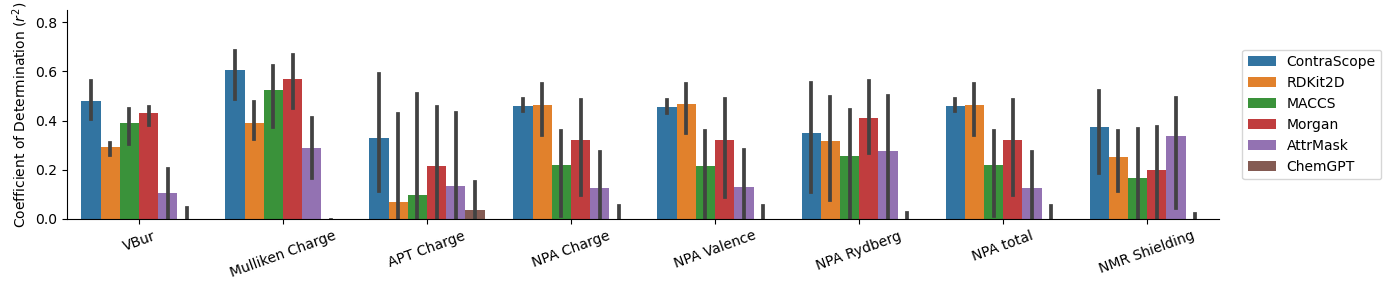

In [42]:
# fig, ax = plt.subplots()

fig, ax = plt.subplots(figsize=(14, 3))

sns.barplot(x='target',
            y='r2',
            hue='embedding',
            data=temp,
            ax=ax)
plt.xticks(rotation=20)
plt.xlabel("")
plt.ylabel(r"Coefficient of Determination ($r^2$)")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.xticks(np.arange(8), ['VBur', 'Mulliken Charge', 'APT Charge', 'NPA Charge', 'NPA Valence', 'NPA Rydberg', 'NPA total', 'NMR Shielding'])

ax.set_ylim(0, 0.85)

ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.show()
# save_fig(ax, 'r_2_locals.pdf')
# plt.savefig('r_2_locals.png', dpi=500, bbox_inches='tight', transparent=True)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt_ = ax.get_figure()
# plt_.show()
plt_.tight_layout()
plt_.savefig('r_2_locals.pdf', transparent=True)

In [35]:
temp = pd.DataFrame(data_list, columns=['embedding', 'target', 'r2'])
temp = temp[temp['target'] != 'local_VBur'][temp['target'] != 'local_Mulliken_charge'][temp['target'] != 'local_APT_charge'][temp['target'] != 'local_NPA_charge'][temp['target'] != 'local_NPA_core'][temp['target'] != 'local_NPA_valence'][temp['target'] != 'local_NPA_Rydberg'][temp['target'] != 'local_NPA_total'][temp['target'] != 'local_NMR_anisotropy'][temp['target'] != 'local_NMR_shift']

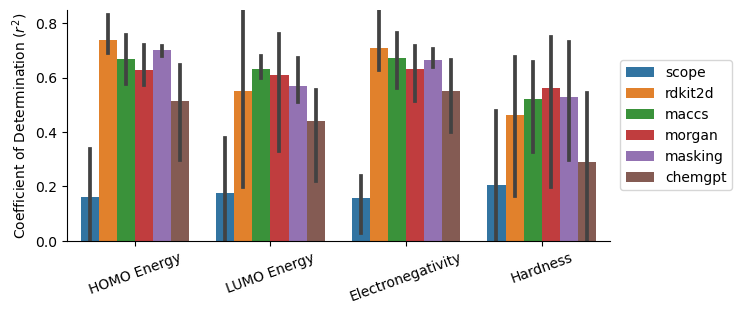

In [39]:
# fig, ax = plt.subplots()

fig, ax = plt.subplots(figsize=(7, 3))

sns.barplot(x='target',
            y='r2',
            hue='embedding',
            data=temp,
            ax=ax)
plt.xticks(rotation=20)
plt.xlabel("")
plt.ylabel(r"Coefficient of Determination ($r^2$)")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.xticks(np.arange(4), ['HOMO Energy', 'LUMO Energy', 'Electronegativity', 'Hardness'])

ax.set_ylim(0, 0.85)

ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.show()
plt.savefig('r_2_globals.png', dpi=500, bbox_inches='tight', transparent=True)

In [19]:
embedding_list = ['ContraScope', 'RDKit2D', 'MACCS', 'Morgan', 'AttrMask', 'ChemGPT']
# prediction_targets = ['local_VBur', 'local_Mulliken_charge', 'local_NPA_charge', 'local_NPA_valence', 'local_NMR_shift']
prediction_targets = ['local_VBur']

# embedding_list = ['scope', 'rdkit2d']
# prediction_targets = ['local_VBur', 'local_Mulliken_charge']

In [16]:
X = embeddings_morgan
y = data['local_Mulliken_charge'].to_numpy()

reg = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)
predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
cv_results = cross_validate(predictor, X, y, cv=3, scoring='r2', return_train_score=True)
cv_results

{'fit_time': array([0.53134108, 0.49841404, 0.52405119]),
 'score_time': array([0.00343227, 0.0033896 , 0.00320673]),
 'test_score': array([0.84729407, 0.83088667, 0.95986443]),
 'train_score': array([0.99256514, 0.9919768 , 0.98363606])}

In [31]:
X = embeddings_morgan
y = data['local_Mulliken_charge'].to_numpy()

reg = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=400, random_state=int(_))
# predictor = make_pipeline(VarianceThreshold(), StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
predictor.fit(X_train, y_train)

r2_score(y_train, predictor.predict(X_train)), r2_score(y_test, predictor.predict(X_test))

(0.9864042005114361, 0.9320888806048004)

In [13]:
data_list = []

for embedding in embedding_list:
    if embedding == 'ContraScope':
        X = embeddings_scope
    elif embedding == 'RDKit2D':
        X = embeddings_rdkit2d
    elif embedding == 'MACCS':
        X = embeddings_maccs
    elif embedding == 'Morgan':
        X = embeddings_morgan
    elif embedding == 'mordred':
        X = embeddings_mordred
    elif embedding == 'AttrMask':
        X = embeddings_masking
    elif embedding == 'ChemGPT':
        X = embeddings_chemgpt
    
    print(f"Embedding: {embedding}")
    for target in prediction_targets:

        print(f"Target: {target}")

        # model_list = ['linear', 'lasso', 'ridge', 'knn', 'svr', 'mlp']
        model_list = ['svr']
        y = data[target].to_numpy()

        for size in [15, 30, 50, 100, 200]:

            max_r2 = -999            

            for model in model_list:
                r2_temp = []

                if model == 'linear':
                    reg = LinearRegression()
                elif model == 'lasso':
                    reg = Lasso(alpha=0.1)
                elif model == 'ridge':
                    reg = Ridge(alpha=.5)
                elif model == 'svr':
                    reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
                elif model == 'mlp':
                    reg = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0)
                elif model == 'knn':
                    reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')

                for _ in range(3):
                    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=int(_))
                    # predictor = make_pipeline(VarianceThreshold(), StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                    predictor = make_pipeline(TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                    predictor.fit(X_train, y_train)
                    y_pred = predictor.predict(X_test)
                    r2_temp.append(r2_score(y_test, y_pred))

                r2_temp = np.array(r2_temp)
                if r2_temp.mean() > max_r2:
                    max_r2 = r2_temp.mean()
                    best_results = r2_temp

            # print(best_results)
            # data_list.append([embedding, target, int(2*size*len(y)/3), cv_results['test_score'].mean(), cv_results['test_score'].std()])
            data_list.append([embedding, target, size, best_results[0]])
            data_list.append([embedding, target, size, best_results[1]])
            data_list.append([embedding, target, size, best_results[2]])

Embedding: ContraScope
Target: global_homo_energy
Target: global_lumo_energy
Target: global_electronegativity
Target: global_hardness
Target: local_VBur
Target: local_Mulliken_charge
Target: local_APT_charge
Target: local_NPA_charge
Target: local_NPA_core
Target: local_NPA_valence
Target: local_NPA_Rydberg
Target: local_NPA_total
Target: local_NMR_shift
Target: local_NMR_anisotropy
Embedding: RDKit2D
Target: global_homo_energy
Target: global_lumo_energy
Target: global_electronegativity
Target: global_hardness
Target: local_VBur
Target: local_Mulliken_charge
Target: local_APT_charge
Target: local_NPA_charge
Target: local_NPA_core
Target: local_NPA_valence
Target: local_NPA_Rydberg
Target: local_NPA_total
Target: local_NMR_shift
Target: local_NMR_anisotropy
Embedding: MACCS
Target: global_homo_energy
Target: global_lumo_energy
Target: global_electronegativity
Target: global_hardness
Target: local_VBur
Target: local_Mulliken_charge
Target: local_APT_charge
Target: local_NPA_charge
Target:

In [14]:
temp2 = pd.DataFrame(data_list, columns=['embedding', 'target', 'size', 'r2'])
temp2

,embedding,target,size,r2
0,ContraScope,global_homo_energy,15,0.012884
1,ContraScope,global_homo_energy,15,-0.018107
2,ContraScope,global_homo_energy,15,0.050410
3,ContraScope,global_homo_energy,30,0.034026
4,ContraScope,global_homo_energy,30,0.176769
...,...,...,...,...
1255,ChemGPT,local_NMR_anisotropy,100,0.059062
1256,ChemGPT,local_NMR_anisotropy,100,0.019669
1257,ChemGPT,local_NMR_anisotropy,200,0.087508
1258,ChemGPT,local_NMR_anisotropy,200,0.049826


In [15]:
temp2.target.unique()

array(['global_homo_energy', 'global_lumo_energy',
       'global_electronegativity', 'global_hardness', 'local_VBur',
       'local_Mulliken_charge', 'local_APT_charge', 'local_NPA_charge',
       'local_NPA_core', 'local_NPA_valence', 'local_NPA_Rydberg',
       'local_NPA_total', 'local_NMR_shift', 'local_NMR_anisotropy'],
      dtype=object)

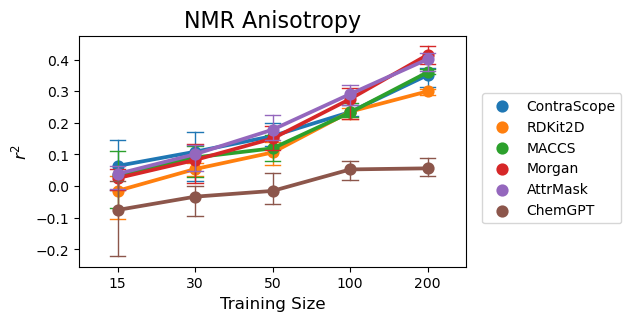

In [65]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.pointplot(x="size", y="r2", hue="embedding", 
              capsize=.2, data=temp2[temp2['target'] == "local_NMR_anisotropy"], errwidth=1, ax=ax)

# Set titles and labels
ax.set_title("NMR Anisotropy", fontsize=16)
ax.set_xlabel("Training Size", fontsize=12)
ax.set_ylabel(r"$r^2$", fontsize=12)

# Adjust legend placement if necessary
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 0.75), borderaxespad=0)

# Show the plot
# plt.show()
fig.savefig('new_curve_for_nmr_anisotropy.png', dpi=200, bbox_inches='tight', transparent=True)

2023-12-18 11:21:39 | INFO | fontTools.subset | maxp pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | cmap pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | kern dropped
2023-12-18 11:21:39 | INFO | fontTools.subset | post pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | FFTM dropped
2023-12-18 11:21:39 | INFO | fontTools.subset | GPOS pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | GSUB pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | glyf pruned
2023-12-18 11:21:39 | INFO | fontTools.subset | Added gid0 to subset
2023-12-18 11:21:39 | INFO | fontTools.subset | Added first four glyphs to subset
2023-12-18 11:21:39 | INFO | fontTools.subset | Closing glyph list over 'GSUB': 5 glyphs before
2023-12-18 11:21:39 | INFO | fontTools.subset | Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'r', 'space']
2023-12-18 11:21:39 | INFO | fontTools.subset | Glyph IDs:   [0, 1, 2, 3, 85]
2023-12-18 11:21:39 | INFO | fontTools.subset | Closed glyph list over 'GSUB'

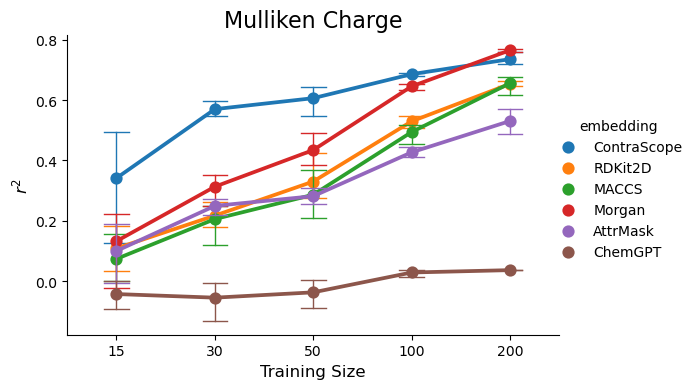

In [17]:
p = sns.catplot(x="size", y="r2", hue="embedding", kind="point", 
            capsize=.25, data=temp2[temp2['target'] == "local_Mulliken_charge"], errwidth=1, height=4, aspect=1.1)
ax = p.axes.flatten()[0]
p._legend.set_bbox_to_anchor((1.2, 0.5)) 
plt.title("Mulliken Charge", fontsize=16)
plt.xlabel("Training Size", fontsize=12)
plt.ylabel(r"$r^2$", fontsize=12)
# plt.xticks(positions, labels)
# plt.show()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt_ = ax.get_figure()
plt_.tight_layout()
plt_.savefig('curve_for_mulcharge.pdf', transparent=True)

2023-12-18 11:22:09 | INFO | fontTools.subset | maxp pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | cmap pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | kern dropped
2023-12-18 11:22:09 | INFO | fontTools.subset | post pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | FFTM dropped
2023-12-18 11:22:09 | INFO | fontTools.subset | GPOS pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | GSUB pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | glyf pruned
2023-12-18 11:22:09 | INFO | fontTools.subset | Added gid0 to subset
2023-12-18 11:22:09 | INFO | fontTools.subset | Added first four glyphs to subset
2023-12-18 11:22:09 | INFO | fontTools.subset | Closing glyph list over 'GSUB': 5 glyphs before
2023-12-18 11:22:09 | INFO | fontTools.subset | Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'r', 'space']
2023-12-18 11:22:09 | INFO | fontTools.subset | Glyph IDs:   [0, 1, 2, 3, 85]
2023-12-18 11:22:09 | INFO | fontTools.subset | Closed glyph list over 'GSUB'

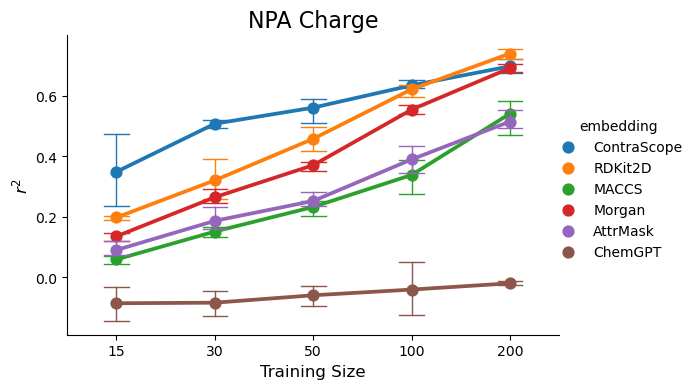

In [18]:
p = sns.catplot(x="size", y="r2", hue="embedding", kind="point", 
            capsize=.25, data=temp2[temp2['target'] == "local_NPA_charge"], errwidth=1, height=4, aspect=1.1)
ax = p.axes.flatten()[0]
p._legend.set_bbox_to_anchor((1.2, 0.5)) 
plt.title("NPA Charge", fontsize=16)
plt.xlabel("Training Size", fontsize=12)
plt.ylabel(r"$r^2$", fontsize=12)
# plt.xticks(positions, labels)
# plt.show()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt_ = ax.get_figure()
plt_.tight_layout()
plt_.savefig('curve_for_npacharge.pdf', transparent=True)

2023-12-18 11:22:34 | INFO | fontTools.subset | maxp pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | cmap pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | kern dropped
2023-12-18 11:22:34 | INFO | fontTools.subset | post pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | FFTM dropped
2023-12-18 11:22:34 | INFO | fontTools.subset | GPOS pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | GSUB pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | glyf pruned
2023-12-18 11:22:34 | INFO | fontTools.subset | Added gid0 to subset
2023-12-18 11:22:34 | INFO | fontTools.subset | Added first four glyphs to subset
2023-12-18 11:22:34 | INFO | fontTools.subset | Closing glyph list over 'GSUB': 5 glyphs before
2023-12-18 11:22:34 | INFO | fontTools.subset | Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'r', 'space']
2023-12-18 11:22:34 | INFO | fontTools.subset | Glyph IDs:   [0, 1, 2, 3, 85]
2023-12-18 11:22:34 | INFO | fontTools.subset | Closed glyph list over 'GSUB'

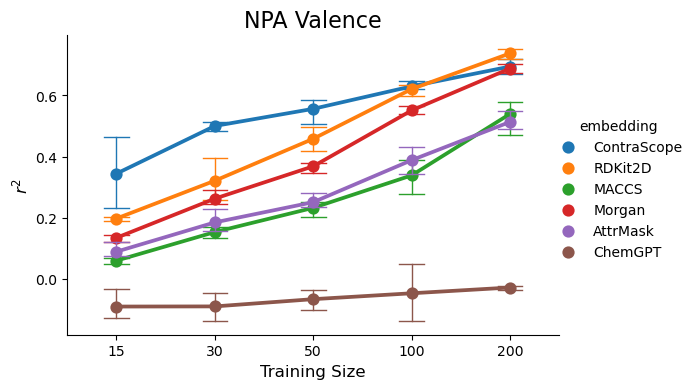

In [19]:
p = sns.catplot(x="size", y="r2", hue="embedding", kind="point", 
            capsize=.25, data=temp2[temp2['target'] == "local_NPA_valence"], errwidth=1, height=4, aspect=1.1)
ax = p.axes.flatten()[0]
p._legend.set_bbox_to_anchor((1.2, 0.5)) 
plt.title("NPA Valence", fontsize=16)
plt.xlabel("Training Size", fontsize=12)
plt.ylabel(r"$r^2$", fontsize=12)
# plt.xticks(positions, labels)
# plt.show()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt_ = ax.get_figure()
plt_.tight_layout()
plt_.savefig('curve_for_npavalence.pdf', transparent=True)

2023-12-18 11:22:57 | INFO | fontTools.subset | maxp pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | cmap pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | kern dropped
2023-12-18 11:22:57 | INFO | fontTools.subset | post pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | FFTM dropped
2023-12-18 11:22:57 | INFO | fontTools.subset | GPOS pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | GSUB pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | glyf pruned
2023-12-18 11:22:57 | INFO | fontTools.subset | Added gid0 to subset
2023-12-18 11:22:57 | INFO | fontTools.subset | Added first four glyphs to subset
2023-12-18 11:22:57 | INFO | fontTools.subset | Closing glyph list over 'GSUB': 5 glyphs before
2023-12-18 11:22:57 | INFO | fontTools.subset | Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'r', 'space']
2023-12-18 11:22:57 | INFO | fontTools.subset | Glyph IDs:   [0, 1, 2, 3, 85]
2023-12-18 11:22:57 | INFO | fontTools.subset | Closed glyph list over 'GSUB'

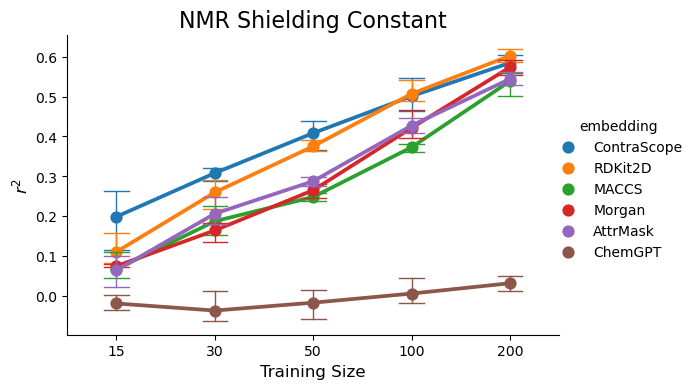

In [20]:
p = sns.catplot(x="size", y="r2", hue="embedding", kind="point", 
            capsize=.25, data=temp2[temp2['target'] == "local_NMR_shift"], errwidth=1, height=4, aspect=1.1)
ax = p.axes.flatten()[0]
p._legend.set_bbox_to_anchor((1.2, 0.5)) 
plt.title("NMR Shielding Constant", fontsize=16)
plt.xlabel("Training Size", fontsize=12)
plt.ylabel(r"$r^2$", fontsize=12)
# plt.xticks(positions, labels)
# plt.show()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt_ = ax.get_figure()
plt_.tight_layout()
plt_.savefig('curve_for_nmr.pdf', transparent=True)

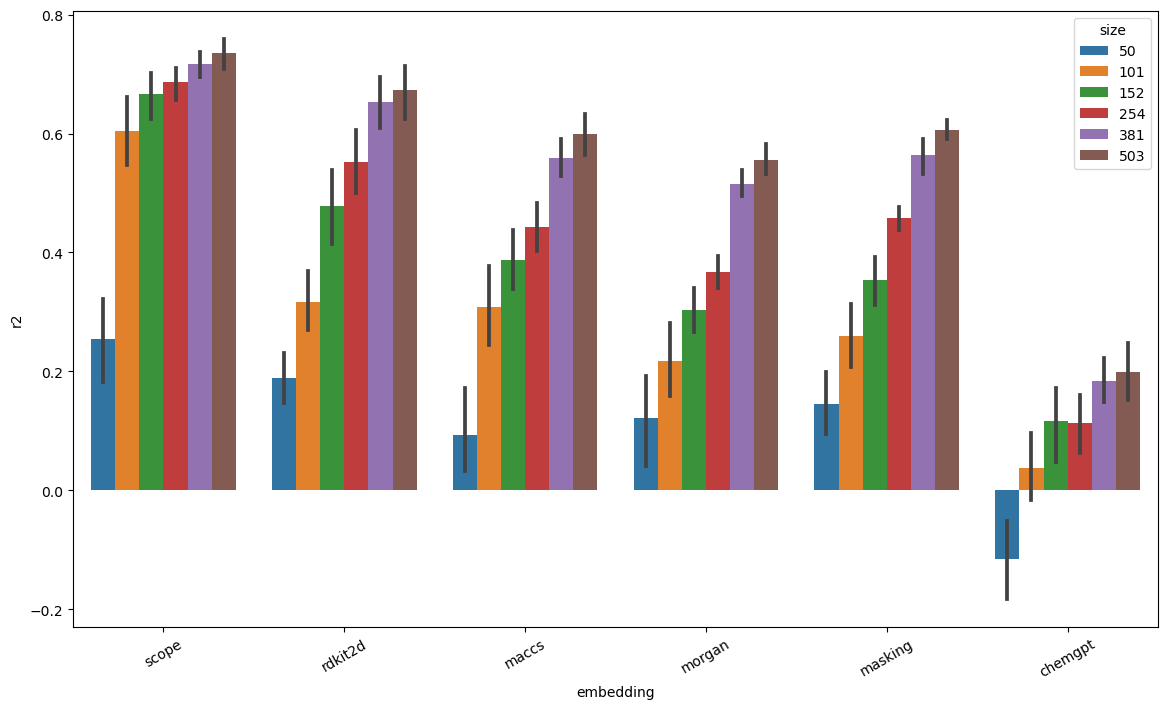

In [64]:
f = plt.figure(figsize=(14, 8))
sns.barplot(x='embedding',
            y='r2',
            hue='size',
            data=temp[temp['target'] != 'global_electronegativity'][temp['target'] != 'global_hardness'])
plt.xticks(rotation=30)
plt.show()